# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [1]:
#%pip install wandb

In [1]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [2]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [3]:
wandb.init(project='precursor_charge_multilabel')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [5]:
#%pip install seaborn

In [4]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [5]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [8]:
import re

def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [7]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [8]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    #if counter > 2:
        #break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [28]:
vocabulary = []
vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
max_len_seq = 0

for df in batches_parquet.values():
    if max_len_seq < df['modified_sequence'].str.len().max():
        max_len_seq = df['modified_sequence'].str.len().max()
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    #annotations = re.findall(r'[A-Z]\[[^\]]*\]|.', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)

In [38]:
print(vocabulary)
voc_len = len(vocabulary)
voc_len

['X', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'C[UNIMOD:4]', 'M[UNIMOD:35]']


23

In [34]:
def seq_translator(sequence, dictionary=vocabulary, max_len=max_len_seq, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param print_result:
    :param max_len:
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications
    #pattern = r'(\w\[UNIMOD:\d+\])' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (max_len - len(result))
    if print_result:
        print(result)

    aa_dictionary = dict()
    for index, aa in enumerate(dictionary):
        aa_dictionary[aa] = index

    return [aa_dictionary[aa] for aa in result]

In [36]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=False))

[1, 1, 21, 10, 10, 18, 1, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [39]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [40]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,LPGSLETYVEQEQGENANDR,2,29525630.0
1,HGSLQEYLQNDTGSK,2,13188580.0
2,VEEEEEINSELTAR,2,20663460.0
3,LPGSLETYVEQEQGENANDR,2,19884630.0
4,NSSTAEINETTTSSTDFLAR,2,12804420.0


In [41]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [42]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Normalisieren:

In [43]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [44]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [45]:
# load all parquets into df
df_dict = dict()
for file in file_list:
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_4760\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_4760\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_4760\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppD

# init merged_df

In [221]:
merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_4760\1215419649.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()


In [222]:
merged_df['distributions'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [223]:
# get percentages for each key in distributions according to values
merged_df['dist_percentages'] = merged_df.apply(lambda x: {key: value / sum(x["distributions"].values()) for key, value in x["distributions"].items()}, axis=1)

In [224]:
def multi_label_one_hot_precursor(charge_list, charges_included=charge_ranges):

    one_hot_encoded = [1 if label in charge_list else 0 for label in charges_included]

    return one_hot_encoded

In [225]:
merged_df['multi_label_vector'] = merged_df['precursor_charge'].apply(multi_label_one_hot_precursor)

In [226]:
merged_df.head(10)

,modified_sequence,precursor_charge,precursor_intensity,distributions,dist_percentages,multi_label_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...","{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 0.09757254940809648, 3: 0.771285358381354,...","[1, 1, 1, 0, 0, 0]"
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",{2: 303307.5},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",{2: 3067981.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....","{2: 8093413.0, 3: 1414907.0}","{2: 0.8511927448802733, 3: 0.14880725511972673}","[0, 1, 1, 0, 0, 0]"
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",{1: 1124818.0},{1: 1.0},"[1, 0, 0, 0, 0, 0]"
5,AAAAAAAAAAAAAAGAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[853119.3, 4332449.0, 3688977.0, 3469130.0, 33...",{1: 679216.3},{1: 1.0},"[1, 0, 0, 0, 0, 0]"
6,AAAAAAAAAAAAAAGGLALGLH,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[33516080.0, 33516080.0, 8522070.0, 4549188.0,...",{2: 365943.3},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
7,AAAAAAAAAAAAAAVTSGV,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...","{2: 14611910.0, 1: 1211272.0}","{2: 0.923449531200488, 1: 0.07655046879951201}","[1, 1, 0, 0, 0, 0]"
8,AAAAAAAAAAAAAGAG,"[1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1233316.0, 2671238.0, 11414430.0, 13683660.0,...","{1: 1879604.0, 2: 2586197.0}","{1: 0.4208884363633758, 2: 0.5791115636366242}","[1, 1, 0, 0, 0, 0]"
9,AAAAAAAAAAAAAK,"[1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...","[2540360.0, 31115000.0, 31115000.0, 70371250.0...","{1: 8372130.0, 2: 15308280.0}","{1: 0.3535466657883035, 2: 0.6464533342116965}","[1, 1, 0, 0, 0, 0]"


In [227]:
merged_df['seq_len_prepadding'] = merged_df['modified_sequence'].apply(lambda x: len(x))

In [228]:
merged_df['seq_len_prepadding'].value_counts()

9      110683
10      71362
11      57432
12      45414
15      37831
        ...  
103         1
115         1
99          1
125         1
108         1
Name: seq_len_prepadding, Length: 103, dtype: int64

In [144]:
len_counts = merged_df['seq_len_prepadding'].value_counts()
seq_too_long = len_counts[len_counts <= 10]
seq_too_long

87     9
82     8
85     7
89     6
90     5
107    4
97     4
95     4
92     4
83     3
86     3
98     3
91     2
84     2
93     2
88     2
96     2
110    2
105    1
104    1
102    1
94     1
103    1
115    1
99     1
125    1
108    1
Name: seq_len_prepadding, dtype: int64

In [229]:
seq_lengths = merged_df['seq_len_prepadding'].value_counts().index.values, merged_df['seq_len_prepadding'].value_counts().values
seq_too_long = pd.DataFrame()
seq_too_long['seq_len'] = seq_lengths[0][seq_lengths[0] >= 50]
seq_too_long['count'] = seq_lengths[1][seq_lengths[0] >= 50]
seq_too_long

,seq_len,count
0,50,1087
1,51,764
2,52,595
3,53,426
4,56,385
5,57,385
6,55,382
7,58,373
8,54,366
9,59,290


In [230]:
# give smallest seq_len when count <= 100
seq_len_cutoff_df = seq_too_long[seq_too_long['count'] <= 100]

In [231]:
seq_len_cutoff = min(seq_len_cutoff_df['seq_len'])

In [232]:
seq_len_cutoff

64

In [233]:
delete_a_row = True
if delete_a_row:
# delete row if seq_len_prepadding larger or equal to seq_len_cutoff
    index_to_delete_seq = merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff].index
    merged_df.drop(index_to_delete_seq, inplace=True)

# seq translator applied

In [234]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator, args=(vocabulary, seq_len_cutoff-1, False))

In [235]:
merged_df.head(11)

,modified_sequence,precursor_charge,precursor_intensity,distributions,dist_percentages,multi_label_vector,seq_len_prepadding,modified_sequence_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...","{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 0.09757254940809648, 3: 0.771285358381354,...","[1, 1, 1, 0, 0, 0]",22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",{2: 303307.5},{2: 1.0},"[0, 1, 0, 0, 0, 0]",21,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",{2: 3067981.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]",22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....","{2: 8093413.0, 3: 1414907.0}","{2: 0.8511927448802733, 3: 0.14880725511972673}","[0, 1, 1, 0, 0, 0]",26,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",{1: 1124818.0},{1: 1.0},"[1, 0, 0, 0, 0, 0]",15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
5,AAAAAAAAAAAAAAGAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[853119.3, 4332449.0, 3688977.0, 3469130.0, 33...",{1: 679216.3},{1: 1.0},"[1, 0, 0, 0, 0, 0]",17,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
6,AAAAAAAAAAAAAAGGLALGLH,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[33516080.0, 33516080.0, 8522070.0, 4549188.0,...",{2: 365943.3},{2: 1.0},"[0, 1, 0, 0, 0, 0]",22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
7,AAAAAAAAAAAAAAVTSGV,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...","{2: 14611910.0, 1: 1211272.0}","{2: 0.923449531200488, 1: 0.07655046879951201}","[1, 1, 0, 0, 0, 0]",19,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18,..."
8,AAAAAAAAAAAAAGAG,"[1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1233316.0, 2671238.0, 11414430.0, 13683660.0,...","{1: 1879604.0, 2: 2586197.0}","{1: 0.4208884363633758, 2: 0.5791115636366242}","[1, 1, 0, 0, 0, 0]",16,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, ..."
9,AAAAAAAAAAAAAK,"[1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...","[2540360.0, 31115000.0, 31115000.0, 70371250.0...","{1: 8372130.0, 2: 15308280.0}","{1: 0.3535466657883035, 2: 0.6464533342116965}","[1, 1, 0, 0, 0, 0]",14,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 0, ..."


In [236]:
len(merged_df)

830820

# Dataset preprocessing

In [237]:
merged_df['multi_label_vector'].value_counts()

[0, 1, 0, 0, 0, 0]    326039
[0, 1, 1, 0, 0, 0]    221905
[0, 0, 1, 0, 0, 0]     96835
[0, 0, 1, 1, 0, 0]     51041
[1, 1, 0, 0, 0, 0]     47644
[1, 0, 0, 0, 0, 0]     25754
[0, 1, 1, 1, 0, 0]     21396
[0, 0, 0, 1, 0, 0]     20796
[0, 0, 0, 1, 1, 0]      5312
[0, 0, 1, 1, 1, 0]      5054
[0, 0, 0, 0, 1, 0]      2374
[0, 1, 0, 1, 0, 0]      1546
[0, 0, 0, 0, 0, 1]      1240
[1, 1, 1, 0, 0, 0]       960
[0, 1, 1, 1, 1, 0]       725
[0, 0, 0, 1, 1, 1]       557
[0, 0, 0, 0, 1, 1]       553
[0, 0, 1, 1, 1, 1]       330
[0, 0, 1, 0, 1, 0]       289
[0, 1, 1, 0, 1, 0]       111
[0, 1, 0, 1, 1, 0]        61
[0, 1, 0, 0, 1, 0]        57
[0, 0, 1, 1, 0, 1]        49
[0, 0, 0, 1, 0, 1]        40
[0, 0, 1, 0, 0, 1]        40
[1, 0, 1, 0, 0, 0]        36
[0, 1, 1, 1, 1, 1]        23
[0, 0, 1, 0, 1, 1]        22
[1, 1, 1, 1, 0, 0]         8
[0, 1, 1, 1, 0, 1]         6
[1, 1, 0, 1, 0, 0]         5
[0, 1, 1, 0, 0, 1]         5
[0, 1, 0, 0, 0, 1]         4
[0, 1, 0, 0, 1, 1]         3
Name: multi_la

In [238]:
value_counts = merged_df['multi_label_vector'].value_counts()
arrays_to_delete_series = value_counts[value_counts <= 20]

In [239]:
arrays_to_delete = arrays_to_delete_series.index.values
delete_a_row = True
if delete_a_row:
    for array in arrays_to_delete:
        index_to_delete = merged_df[merged_df['multi_label_vector'].apply(lambda x: np.array_equal(x, array))].index
        merged_df.drop(index_to_delete, inplace=True)

In [240]:
merged_df['multi_label_vector'].value_counts().index.values

array([list([0, 1, 0, 0, 0, 0]), list([0, 1, 1, 0, 0, 0]),
       list([0, 0, 1, 0, 0, 0]), list([0, 0, 1, 1, 0, 0]),
       list([1, 1, 0, 0, 0, 0]), list([1, 0, 0, 0, 0, 0]),
       list([0, 1, 1, 1, 0, 0]), list([0, 0, 0, 1, 0, 0]),
       list([0, 0, 0, 1, 1, 0]), list([0, 0, 1, 1, 1, 0]),
       list([0, 0, 0, 0, 1, 0]), list([0, 1, 0, 1, 0, 0]),
       list([0, 0, 0, 0, 0, 1]), list([1, 1, 1, 0, 0, 0]),
       list([0, 1, 1, 1, 1, 0]), list([0, 0, 0, 1, 1, 1]),
       list([0, 0, 0, 0, 1, 1]), list([0, 0, 1, 1, 1, 1]),
       list([0, 0, 1, 0, 1, 0]), list([0, 1, 1, 0, 1, 0]),
       list([0, 1, 0, 1, 1, 0]), list([0, 1, 0, 0, 1, 0]),
       list([0, 0, 1, 1, 0, 1]), list([0, 0, 0, 1, 0, 1]),
       list([0, 0, 1, 0, 0, 1]), list([1, 0, 1, 0, 0, 0]),
       list([0, 1, 1, 1, 1, 1]), list([0, 0, 1, 0, 1, 1])], dtype=object)

In [241]:
multi_label_classes_num = merged_df['multi_label_vector'].value_counts().index.values.shape[0]
multi_label_classes_num

28

In [242]:
len(merged_df['multi_label_vector'])

830789

### Model

# Embedding model test:

In [286]:
main_ds_embed = np.array(merged_df["modified_sequence_vector"]) # to list
main_labels_embed = np.array(merged_df['multi_label_vector'])

In [287]:
len(main_ds_embed), len(main_labels_embed)

(830789, 830789)

In [288]:
# Create an instance of StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform the split train+val and test
trainval_indicies_embed, test_indicies_embed = next(sss1.split(main_ds_embed, main_ds_labels_embed))

trainval_ds_embed, trainval_labels_embed = main_ds_embed[trainval_indicies_embed], main_labels_embed[trainval_indicies_embed]
test_ds_embed, test_labels_embed = main_ds_embed[test_indicies_embed], main_labels_embed[test_indicies_embed]

In [289]:
# Perform the split train and val
train_indicies_embed, val_indicies_embed = next(sss2.split(trainval_ds_embed, trainval_labels_embed))

train_ds_embed, train_labels_embed = trainval_ds_embed[train_indicies_embed], trainval_labels_embed[train_indicies_embed]
val_ds_embed, val_labels_embed = trainval_ds_embed[val_indicies_embed], trainval_labels_embed[val_indicies_embed]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

In [290]:
len(train_ds_embed), len(train_ds_labels_embed)

(523397, 523397)

In [291]:
len(val_ds_embed), len(val_ds_labels_embed)

(224313, 224313)

In [292]:
len(test_ds_embed), len(test_labels_embed)

(83079, 83079)

In [293]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]
test_ds_embed = [np.array(x) for x in test_ds_embed]

In [294]:
train_labels_embed = [np.array(x) for x in train_labels_embed]
val_labels_embed = [np.array(x) for x in val_labels_embed]
test_labels_embed = [np.array(x) for x in test_labels_embed]

In [295]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_labels_embed = tf.convert_to_tensor(train_labels_embed)
val_labels_embed = tf.convert_to_tensor(val_labels_embed)

test_ds_embed = tf.convert_to_tensor(test_ds_embed)
test_labels_embed = tf.convert_to_tensor(test_labels_embed)

In [296]:
train_labels_embed[0]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([0, 1, 0, 0, 0, 0])>

In [297]:
train_ds_embed.shape

TensorShape([523397, 63])

In [52]:
#wandb.init(project='precursor_charge_multilabel')

In [306]:
seq_len_after_cutoff = seq_len_cutoff-1

from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
x = Model(inputs=inputA_embed, outputs=inputA_embed)
y = Embedding(input_dim=voc_len, output_dim=50, input_length=50)(inputA_embed)
y = Flatten()(y)
y = Dense(seq_len_after_cutoff, activation="relu")(y)
z = Dense(num_classes, activation="sigmoid")(y)
model_embed = Model(inputs=[x.input], outputs=z)

In [307]:
model_embed.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 63)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 63, 50)            1150      
                                                                 
 flatten_6 (Flatten)         (None, 3150)              0         
                                                                 
 dense_12 (Dense)            (None, 63)                198513    
                                                                 
 dense_13 (Dense)            (None, 6)                 384       
                                                                 
Total params: 200,047
Trainable params: 200,047
Non-trainable params: 0
_________________________________________________________________


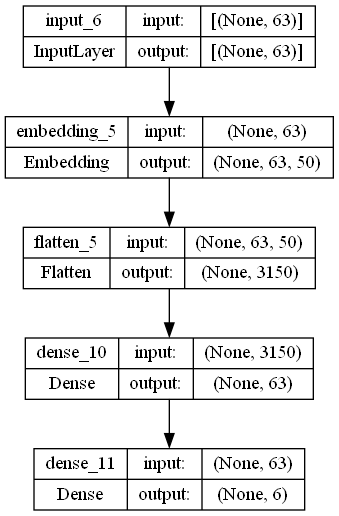

In [301]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [308]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['binary_accuracy'])

In [309]:
checkpoint_callback_embed = ModelCheckpoint('precursor_charge_prediction_model_embed/embed_multi_label.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_embed = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_labels_embed, epochs=25, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()]) #WandbCallback()

Epoch 1/25
127/128 [============================>.] - ETA: 0s - loss: 0.2331 - binary_accuracy: 0.9080WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_093915-vri52hbm\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230821_093915-vri52hbm\files\model-best)... Done. 0.0s


128/128 [==============================] - 6s 46ms/step - loss: 0.2331 - binary_accuracy: 0.9080 - val_loss: 0.2242 - val_binary_accuracy: 0.9141
Epoch 2/25
 65/128 [==============>...............] - ETA: 2s - loss: 0.2205 - binary_accuracy: 0.9162

In [61]:
import datetime
date = datetime.datetime.now().strftime("%m%d%Y")
print(date)

08172023


In [60]:
model_embed.save(f'precursor_charge_prediction_model_embed/history_embed_150epoch_{date}.h5')

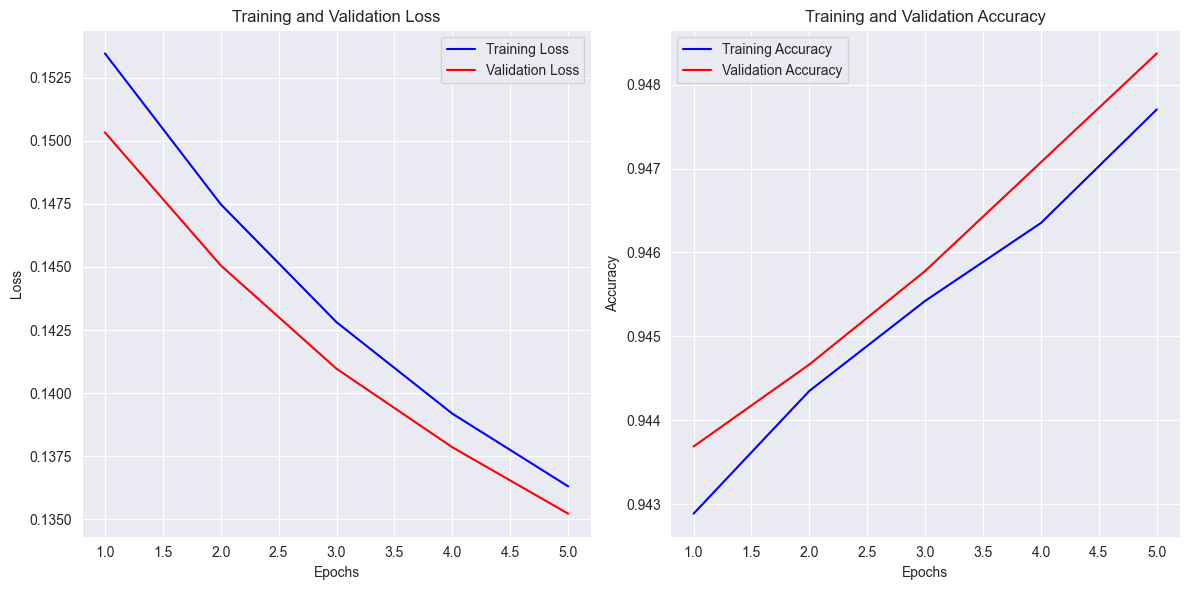

In [62]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
#accuracy = history_embed.history['categorical_accuracy']
accuracy = history_embed.history['binary_accuracy']
val_accuracy = history_embed.history['val_binary_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Inference

In [63]:
file_list[-1]

'data/TUM_third_pool_meta_data.parquet'

In [64]:
batches_parquet[file_list[-1]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,DNYDQLVRIAK,2,141925100.0
1,MDLESQISDMR,2,63760280.0
2,QLQQIERQLK,2,19577780.0
3,PC[UNIMOD:4]C[UNIMOD:4]C[UNIMOD:4]QTTC[UNIMOD:...,2,29736720.0
4,LNTEVTTWRTK,2,59018990.0


In [65]:
# Grouping by "modified_sequence" and aggregating precursor_charge into a list
grouped_df_embed = batches_parquet[file_list[-1]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

grouped_df_embed['distributions'] = grouped_df_embed.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)
# get percentages for each key in distributions according to values
grouped_df_embed['dist_percentages'] = merged_df.apply(lambda x: {key: value / sum(x["distributions"].values()) for key, value in x["distributions"].items()}, axis=1)
# get percentages for each key in distributions according to values
grouped_df_embed['dist_percentages'] = grouped_df_embed.apply(lambda x: {key: value / sum(x["distributions"].values()) for key, value in x["distributions"].items()}, axis=1)
grouped_df_embed['multi_label_vector'] = grouped_df_embed['precursor_charge'].apply(multi_label_one_hot_precursor)

grouped_df_embed["modified_sequence_vector"] = grouped_df_embed["modified_sequence"].apply(seq_translator)
# grouped_df_embed["precursor_charge"] = grouped_df_embed["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
# grouped_df_embed.rename(columns={"precursor_charge": "most_abundant_charge_vector"}, inplace=True)
# grouped_df_embed = grouped_df_embed.drop("precursor_intensity", axis=1)
# grouped_df_embed = grouped_df_embed.drop("modified_sequence", axis=1)
# grouped_df_embed

C:\Users\micro\AppData\Local\Temp\ipykernel_31132\2986331777.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df_embed = batches_parquet[file_list[-1]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


In [66]:
grouped_df_embed.head()

,modified_sequence,precursor_charge,precursor_intensity,distributions,dist_percentages,multi_label_vector,modified_sequence_vector
0,AAAHGQWELQR,"[2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, ...","[28830290.0, 54193450.0, 140640000.0, 24331800...","{2: 2468948.0, 3: 1297622.0}","{2: 0.6554897426571125, 3: 0.34451025734288754}","[0, 1, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100..."
1,AAAHGQWELQRVHAK,"[3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 4, 3, 3, 3, ...","[51900020.0, 107239100.0, 51900020.0, 10723910...","{3: 2724071.0, 2: 392950.3, 4: 5230219.0}","{3: 0.32634390554205084, 2: 0.0470754747530150...","[0, 1, 1, 1, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100..."
2,AAEADGPLK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[463096400.0, 23056760.0, 463096400.0, 3299108...",{2: 2546133.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900..."
3,AAEADGPLKR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[12753870.0, 12753870.0, 4429177.0, 9050965.0,...",{2: 6452822.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900..."
4,AAIRLELFLPPQLK,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[25908740.0, 19976810.0, 19976810.0, 9842920.0...",{3: 159833.2},{3: 1.0},"[0, 0, 1, 0, 0, 0]","[100, 100, 800, 1500, 1000, 400, 1000, 500, 10..."


In [67]:
# size of df
grouped_df_embed.shape

(4358, 7)

In [67]:
# ValueError: Layer "model_1" expects 1 input(s), but it received 33732 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 50) dtype=int32>, <tf.Tensor

In [68]:
# solut = [np.expand_dims(tf.convert_to_tensor(np.array(x)), axis=0) for x in grouped_df_embed["modified_sequence_vector"]]
# predictions = model_embed.predict(solut, batch_size=4096, verbose=True)

In [68]:
grouped_df_embed['prediction'] = None
for index, row in grouped_df_embed.iterrows():
    solut = np.expand_dims(tf.convert_to_tensor(np.array(grouped_df_embed.at[index, "modified_sequence_vector"])), axis=0)
    grouped_df_embed.at[index, 'prediction'] = model_embed.predict(solut, verbose=False)

In [69]:
charge_state_labels = pd.DataFrame()
charge_state_labels['labels'] = merged_df['multi_label_vector'].value_counts().index.values
# add index column
charge_state_labels['index'] = [x for x in range(len(merged_df['multi_label_vector'].value_counts().index.values))]

In [70]:
#create dict from dataframe, keys are labels, values are index
charge_state_labels_dict = charge_state_labels.to_dict()['labels']
charge_state_labels_dict

{0: [0, 1, 0, 0, 0, 0],
 1: [0, 1, 1, 0, 0, 0],
 2: [0, 0, 1, 0, 0, 0],
 3: [1, 1, 0, 0, 0, 0],
 4: [0, 0, 1, 1, 0, 0],
 5: [1, 0, 0, 0, 0, 0],
 6: [0, 1, 1, 1, 0, 0],
 7: [0, 0, 0, 1, 0, 0],
 8: [0, 0, 1, 1, 1, 0],
 9: [0, 0, 0, 1, 1, 0],
 10: [0, 0, 0, 0, 1, 0],
 11: [0, 1, 0, 1, 0, 0],
 12: [1, 1, 1, 0, 0, 0],
 13: [0, 0, 0, 0, 0, 1],
 14: [0, 1, 1, 1, 1, 0],
 15: [0, 0, 0, 1, 1, 1],
 16: [0, 0, 0, 0, 1, 1],
 17: [0, 0, 1, 1, 1, 1],
 18: [0, 0, 1, 0, 1, 0],
 19: [0, 1, 1, 0, 1, 0],
 20: [0, 1, 0, 1, 1, 0],
 21: [0, 1, 0, 0, 1, 0],
 22: [1, 0, 1, 0, 0, 0],
 23: [0, 0, 1, 1, 0, 1],
 24: [0, 1, 1, 1, 1, 1],
 25: [0, 0, 0, 1, 0, 1],
 26: [0, 0, 1, 0, 0, 1],
 27: [0, 0, 1, 0, 1, 1],
 28: [1, 1, 1, 1, 0, 0],
 29: [1, 1, 0, 1, 0, 0],
 30: [0, 1, 1, 1, 0, 1],
 31: [0, 1, 0, 0, 0, 1],
 32: [0, 1, 1, 0, 0, 1],
 33: [0, 1, 0, 0, 1, 1]}

In [71]:
def decode_one_hot(one_hot, charges = [1,2,3,4,5,6]):
    for index, hot in enumerate(one_hot):
        if hot == 1:
            return charges[index]

In [72]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    index = np.argmax(one_hot)
    return(charges[index])

In [73]:
np.argmax([0, 0 ,0 ,0, 1])

4

In [75]:
merged_df['multi_label_vector'].count_values()

AttributeError: 'Series' object has no attribute 'count_values'

In [76]:
grouped_df_embed['true_label'] = grouped_df_embed['multi_label_vector'].apply(decode_one_hot)

In [77]:
grouped_df_embed['pred_label'] = grouped_df_embed['prediction'].apply(predictions_no_hot)

In [78]:
grouped_df_embed.head(4)

,modified_sequence,precursor_charge,precursor_intensity,distributions,dist_percentages,multi_label_vector,modified_sequence_vector,prediction,true_label,pred_label
0,AAAHGQWELQR,"[2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, ...","[28830290.0, 54193450.0, 140640000.0, 24331800...","{2: 2468948.0, 3: 1297622.0}","{2: 0.6554897426571125, 3: 0.34451025734288754}","[0, 1, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100...","[[0.004067875, 0.92822176, 0.91246784, 0.00452...",2,2
1,AAAHGQWELQRVHAK,"[3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 4, 3, 3, 3, ...","[51900020.0, 107239100.0, 51900020.0, 10723910...","{3: 2724071.0, 2: 392950.3, 4: 5230219.0}","{3: 0.32634390554205084, 2: 0.0470754747530150...","[0, 1, 1, 1, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100...","[[5.1795723e-06, 0.0858191, 0.8777329, 0.96380...",2,4
2,AAEADGPLK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[463096400.0, 23056760.0, 463096400.0, 3299108...",{2: 2546133.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900...","[[0.3592155, 0.94083583, 0.0050586252, 0.00017...",2,2
3,AAEADGPLKR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[12753870.0, 12753870.0, 4429177.0, 9050965.0,...",{2: 6452822.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900...","[[0.003330212, 0.9659049, 0.8330883, 0.0023459...",2,2


In [79]:
# iterate all rows of grouped_df_embed
size_of_df = grouped_df_embed.shape[0]
true_counter = 0
for index, row in grouped_df_embed.iterrows():
    if row['true_label'] == row['pred_label']:
        true_counter += 1

print(true_counter/size_of_df, true_counter, size_of_df)

0.7042221202386416 3069 4358


[[   0    7    0    0    0    0]
 [   0 1655  959   12    0    0]
 [   1   57 1315  137    0    0]
 [   0    2  105   99    0    0]
 [   0    0    4    2    0    0]
 [   0    0    0    3    0    0]]
Accuracy:  0.7042221202386416
Precision:  0.7891598277188109
Recall:  0.7042221202386416
F1:  0.7132926763834826


C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


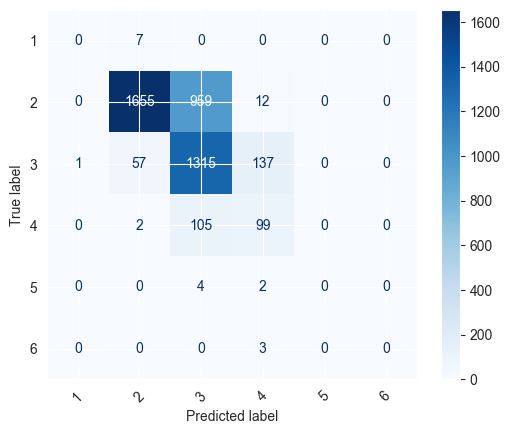

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

true_labels = grouped_df_embed['true_label']
predicted_labels = grouped_df_embed['pred_label']

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
print("Precision: ", precision_score(true_labels, predicted_labels, average='weighted'))
print("Recall: ", recall_score(true_labels, predicted_labels, average='weighted'))
print("F1: ", f1_score(true_labels, predicted_labels, average='weighted'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

In [ ]:
from sklearn.metrics import confusion_matrix

new_df = pd.DataFrame(columns=['charge','accuracy'])

matrix = confusion_matrix(true_labels, predicted_labels)
new_df['charge'] = [1,2,3,4,5,6]
new_df['accuracy'] = matrix.diagonal()/matrix.sum(axis=1)


In [ ]:
new_df

In [ ]:
grouped_df_embed.head(4)

# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [ ]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

In [ ]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

In [ ]:
batches_parquet.keys()

In [ ]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [ ]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [ ]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [ ]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

MCC

In [ ]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

Direct eval:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [ ]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')